<a href="https://colab.research.google.com/github/adventurousAyan/MLAppB81A/blob/main/Final_Hack_3671_Ayan_Jana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, recall_score,confusion_matrix, precision_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
import seaborn as sns
%matplotlib inline

In [37]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/traindata_without_target.csv")

In [127]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

In [7]:
data.dtypes

date               datetime64[ns]
farm_id                    object
ingredient_type            object
dtype: object

In [11]:
data.set_index('date', inplace=True)

In [12]:
data.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=20216100, freq=None)

In [13]:
data.groupby(pd.Grouper(freq="W")) 

In [19]:
df = data.groupby(pd.Grouper(freq="W"))

In [21]:
pd.set_option('display.max_rows', None)

In [99]:
class CustomEDA:     
    """Custom Exploratory Data Analysis Class"""    
    
    def fn_nulls_count(self, df):
        """Function to count the null values and their percentages in each column."""
        # Nulls counts in each column.
        nulls_counts = df.isnull().sum()
        # Convert above series into dataframe.
        nulls_counts_df = nulls_counts.to_frame(name = 'nulls_count')
        # Add a new column - to get the null counts percentage to the total rows.
        nulls_counts_df['nulls_percentage'] = round(100 * nulls_counts_df['nulls_count']/df.shape[0], 2)
        # Return the null counts dataframe.
        return nulls_counts_df
    
    def fn_plot_residuals(self, df):
        """Function to plot residuals in data."""
        # retrieve data as numpy array
        values = df.values
        print(values.shape)
        # create a subplot for each time series
        plt.figure(figsize=(16, 16))
        for i in range(values.shape[1]):
            plt.subplot(values.shape[1], 1, i+1)
            plt.plot(values[:, i])
        plt.show()
    
    
    def fn_compute_outliers(self, df):
        """Function to check for outliers in data."""
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        cleaned_eeg_df = df[~((df < (Q1 - 1.5 * IQR)) |
                                  (df > (Q3 + 1.5 * IQR)))\
                                .any(axis=1)]
        print(cleaned_eeg_df.shape)
    
    
    def fn_plot_correlation(self, df):
        """Function to plot the correlation in data."""
        plt.figure(figsize=(12,7))
        sns.heatmap(df.corr(), annot=True)
        plt.xticks(rotation=45)
        plt.show()
    
    def fn_check_and_drop_duplicates(self, df):
        """Function to check and drop duplicates in data."""
        duplicate = df[df.duplicated()]  
        print("Duplicate Rows :")  
        #Print the resultant Dataframe 
        duplicate 
        df_duplicates_removed = pd.DataFrame.drop_duplicates(df)
        print(df_duplicates_removed)
        return df_duplicates_removed

    def fn_compute_metrics(self, model, x_train, x_test, y_train, y_test, iter_no, model_name):
        """Function to compute metrics after the model has been built. 
           Takes model_name as in input parameter to store results of various models 
           Uses a dataframe metric_data to store the results of various runs across various ML models
        """
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print(model.score(x_train, y_train))
        print(model.score(x_test, y_test))
        print("\n")
        confusion_matrix_train = confusion_matrix(y_true=y_train, y_pred = train_pred)
        confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)
        print(confusion_matrix_train)   
        print(confusion_matrix_test)   

        f1 = f1_score(y_train,train_pred)
        recall = recall_score(y_train,train_pred)
        accuracy = accuracy_score(y_train,train_pred)
        prec = precision_score(y_train, train_pred)
        metric_data.loc[metric_data.shape[0]] = [iter_no,model_name,'Train',accuracy,f1,recall, prec] 

        f1_test = f1_score(y_test,test_pred)
        rc_test = recall_score(y_test,test_pred)
        ac_test = accuracy_score(y_test,test_pred)
        prec_test = precision_score(y_test, test_pred)
        metric_data.loc[metric_data.shape[0]] = [iter_no,model_name,'Test',ac_test,f1_test,rc_test, prec_test] 
        print(classification_report(y_train,train_pred))
    
    def fn_set_up_metric_data(self):
        """Intialiazes the metric_data to store result of various runs"""
        metric_data = pd.DataFrame(columns = ['Iteration No', 'Model Name','Method Type','Accuracy Score','F1 score','Recall Score', 'Precision Score'])
        return metric_data
    
    def fn_fetch_col_based_ontype(self, df, *args):
        """Function to return column based on column type"""
        return df.select_dtypes(include=args).columns.tolist()
    
    def fn_get_data_information(self, df):
        """Function to fetch data-frame information"""
        print(f'Shape of dataframe is {df.shape}')
        print('*************************************************************')
        print("DataFrame information")
        print(df.info())
        print('************************************************************')
        print("DataFrame Summary")
        print(df.describe())
        
    def fn_plot_pairplots(self, df, targetCol):
        for i in range(0, len(df.columns), 5):
                sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=[targetCol])
                
    def fn_plot_regplot(self, df, features_to_analyse, targetCol):
        fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))
        for i, ax in enumerate(fig.axes):
            if i < len(features_to_analyse) - 1:
                sns.regplot(x=features_to_analyse[i],y=targetCol, data=df[features_to_analyse], ax=ax)
                
    def fn_plot_countplot(self, df_not_num):
        fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))
        for i, ax in enumerate(fig.axes):
            if i < len(df_not_num.columns):
                ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
                sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)
        fig.tight_layout() 
    
    def fn_plot_histplot(self, df_num):
        df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
        
    def fn_nulls_plot(self,df):
        plt.figure(figsize = (12,6))
        sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
        plt.xticks(rotation=45)
        plt.show()

In [51]:
farm_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/farm_data.csv")
weather_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train_weather.csv")

In [24]:
print(data.shape)
print("*"*25)
print(farm_data.shape)
print("*"*25)
print(weather_data.shape)

(20216100, 2)
*************************
(1449, 6)
*************************
(139773, 9)


In [25]:
data.head()

,farm_id,ingredient_type
date,,
2016-01-01,fid_110884,ing_w
2016-01-01,fid_90053,ing_w
2016-01-01,fid_17537,ing_w
2016-01-01,fid_110392,ing_w
2016-01-01,fid_62402,ing_w


In [26]:
data.tail()

,farm_id,ingredient_type
date,,
2016-12-31 23:00:00,fid_41664,ing_w
2016-12-31 23:00:00,fid_14529,ing_w
2016-12-31 23:00:00,fid_46454,ing_w
2016-12-31 23:00:00,fid_24103,ing_w
2016-12-31 23:00:00,fid_34139,ing_w


In [27]:
data.nunique()

farm_id            1434
ingredient_type       4
dtype: int64

In [28]:
data['ingredient_type'].unique()

array(['ing_w', 'ing_z', 'ing_x', 'ing_y'], dtype=object)

In [29]:
farm_data.head()

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_90053,2004.0,NaN,252.696160,Obery Farms,location 7369
2,fid_17537,1991.0,NaN,499.446528,Obery Farms,location 7369
3,fid_110392,2002.0,NaN,2200.407555,Obery Farms,location 7369
4,fid_62402,1975.0,NaN,10833.140121,Obery Farms,location 7369


In [30]:
farm_data.tail()

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
1444,fid_41664,1914.0,NaN,1822.663957,Sanderson Farms,location 5150
1445,fid_14529,NaN,NaN,399.297094,Obery Farms,location 5150
1446,fid_46454,1997.0,NaN,1046.552295,Sanderson Farms,location 5150
1447,fid_24103,2001.0,NaN,2766.186825,Dole Food Company,location 5150
1448,fid_34139,2001.0,NaN,8572.252713,Wayne Farms,location 5150


In [31]:
farm_data.nunique()

farm_id                       1434
operations_commencing_year     116
num_processing_plants           18
farm_area                     1397
farming_company                 16
deidentified_location           16
dtype: int64

In [32]:
farm_data.dtypes

farm_id                        object
operations_commencing_year    float64
num_processing_plants         float64
farm_area                     float64
farming_company                object
deidentified_location          object
dtype: object

In [33]:
weather_data.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01 00:00:00,location 7369,25.0,6.0,0.0,20.0,1019.7,NaN,0.0
1,2016-01-01 01:00:00,location 7369,24.4,NaN,70.0,21.1,1020.2,-1.0,1.5
2,2016-01-01 02:00:00,location 7369,22.8,2.0,0.0,21.1,1020.2,0.0,0.0
3,2016-01-01 03:00:00,location 7369,21.1,2.0,0.0,20.6,1020.1,0.0,0.0
4,2016-01-01 04:00:00,location 7369,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6


In [34]:
weather_data.tail()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
139768,2016-12-31 19:00:00,location 5150,3.0,NaN,180.0,-8.0,NaN,NaN,5.7
139769,2016-12-31 20:00:00,location 5150,2.8,2.0,180.0,-8.9,1007.4,NaN,7.7
139770,2016-12-31 21:00:00,location 5150,2.8,NaN,180.0,-7.2,1007.5,NaN,5.1
139771,2016-12-31 22:00:00,location 5150,2.2,NaN,170.0,-6.7,1008.0,NaN,4.6
139772,2016-12-31 23:00:00,location 5150,1.7,NaN,180.0,-5.6,1008.5,-1.0,8.8


In [35]:
weather_data.nunique()

timestamp                8784
deidentified_location      16
temp_obs                  619
cloudiness                 10
wind_direction             43
dew_temp                  522
pressure_sea_level        709
precipitation             128
wind_speed                 58
dtype: int64

In [36]:
weather_data.dtypes

timestamp                 object
deidentified_location     object
temp_obs                 float64
cloudiness               float64
wind_direction           float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
dtype: object

In [52]:
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
weather_data['timestamp'] = weather_data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [53]:
weather_data['timestamp'].unique()

array(['2016-01-01T00:00:00.000000000', '2016-01-01T01:00:00.000000000',
       '2016-01-01T02:00:00.000000000', ...,
       '2016-12-31T21:00:00.000000000', '2016-12-31T22:00:00.000000000',
       '2016-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [54]:
weather_data['date_timestamp'] = weather_data['timestamp'].dt.date

In [56]:
weather_data.drop('timestamp', axis=1, inplace=True)

In [55]:
weather_data.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,date_timestamp
0,2016-01-01 00:00:00,location 7369,25.0,6.0,0.0,20.0,1019.7,NaN,0.0,2016-01-01
1,2016-01-01 01:00:00,location 7369,24.4,NaN,70.0,21.1,1020.2,-1.0,1.5,2016-01-01
2,2016-01-01 02:00:00,location 7369,22.8,2.0,0.0,21.1,1020.2,0.0,0.0,2016-01-01
3,2016-01-01 03:00:00,location 7369,21.1,2.0,0.0,20.6,1020.1,0.0,0.0,2016-01-01
4,2016-01-01 04:00:00,location 7369,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6,2016-01-01


In [39]:
# Convert few columns to categories
col_to_be_converted = ['farm_id', 'operations_commencing_year','farming_company','deidentified_location']
farm_data[col_to_be_converted] = farm_data[col_to_be_converted].astype('category')
farm_data.dtypes

farm_id                       category
operations_commencing_year    category
num_processing_plants          float64
farm_area                      float64
farming_company               category
deidentified_location         category
dtype: object

In [40]:
df = pd.merge(data, farm_data, on="farm_id")

In [41]:
df.head()

,date,farm_id,ingredient_type,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,2016-01-01 00:00:00,fid_110884,ing_w,2008.0,NaN,690.455096,Obery Farms,location 7369
1,2016-01-01 01:00:00,fid_110884,ing_w,2008.0,NaN,690.455096,Obery Farms,location 7369
2,2016-01-01 02:00:00,fid_110884,ing_w,2008.0,NaN,690.455096,Obery Farms,location 7369
3,2016-01-01 03:00:00,fid_110884,ing_w,2008.0,NaN,690.455096,Obery Farms,location 7369
4,2016-01-01 04:00:00,fid_110884,ing_w,2008.0,NaN,690.455096,Obery Farms,location 7369


In [42]:
df['farm_id'].nunique()


1434

In [43]:

df['deidentified_location'].nunique()



16

In [44]:
df[df.farm_id == 'fid_110884'].deidentified_location.unique()


['location 7369']
Categories (1, object): ['location 7369']

In [45]:

df[df.deidentified_location == 'location 7369'].farm_id.unique()

array(['fid_110884', 'fid_90053', 'fid_17537', 'fid_110392', 'fid_62402',
       'fid_121604', 'fid_85694', 'fid_33785', 'fid_110793', 'fid_32954',
       'fid_61445', 'fid_20096', 'fid_56102', 'fid_43573', 'fid_48575',
       'fid_109906', 'fid_34103', 'fid_57758', 'fid_48075', 'fid_64013',
       'fid_76740', 'fid_20789', 'fid_32291', 'fid_115413', 'fid_69590',
       'fid_100807', 'fid_105085', 'fid_44304', 'fid_102416', 'fid_29482',
       'fid_38448', 'fid_56855', 'fid_63385', 'fid_46223', 'fid_116934',
       'fid_111680', 'fid_49528', 'fid_15951', 'fid_120178', 'fid_80442',
       'fid_74101', 'fid_76042', 'fid_107841', 'fid_70417', 'fid_110278',
       'fid_51884', 'fid_12776', 'fid_94807', 'fid_87168', 'fid_112127',
       'fid_28622', 'fid_73322', 'fid_111986', 'fid_57916', 'fid_68605',
       'fid_88913', 'fid_119338', 'fid_46725', 'fid_97363', 'fid_14189',
       'fid_21897', 'fid_47782', 'fid_107436', 'fid_107874', 'fid_40459',
       'fid_12360', 'fid_105593', 'fid_24658'

In [46]:
weather_data.shape

(139773, 9)

In [47]:
weather_data.columns

Index(['timestamp', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')

In [60]:
#df2 = pd.merge(df, weather_data, on="deidentified_location")
df_weather = weather_data.groupby(['date_timestamp','deidentified_location'])\
.agg({'temp_obs':np.mean,'cloudiness':np.mean, 'dew_temp': np.mean, 'pressure_sea_level':np.mean, 'precipitation': np.mean, 'wind_speed':np.mean})

df_weather.reset_index()


,date_timestamp,deidentified_location,temp_obs,cloudiness,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01,location 1784,-12.239130,0.000000,-16.717391,1035.743478,0.000000,2.869565
1,2016-01-01,location 2532,-6.229167,2.666667,-10.283333,1020.216667,-0.217391,4.737500
2,2016-01-01,location 4525,-1.841667,NaN,-3.270833,1012.554167,3.750000,3.000000
3,2016-01-01,location 5150,-1.357143,NaN,-3.000000,NaN,NaN,4.407143
4,2016-01-01,location 5290,6.679167,7.750000,-0.650000,1020.625000,0.000000,4.133333
5,2016-01-01,location 5410,3.934783,1.250000,-3.282609,1017.747826,0.000000,3.373913
6,2016-01-01,location 5489,9.762500,0.869565,-4.620833,1017.766667,0.000000,0.895833
7,2016-01-01,location 565,6.717391,0.100000,0.926087,1019.809091,0.000000,1.317391
8,2016-01-01,location 5677,23.337500,4.285714,20.020833,1018.926087,-0.173913,1.854167
9,2016-01-01,location 5833,6.056522,0.956522,-4.982609,1021.243478,0.000000,2.573913


In [63]:
df_weather.shape

(5856, 6)

In [64]:
df_weather.isnull().sum()

temp_obs                 0
cloudiness            1075
dew_temp                 0
pressure_sea_level     375
precipitation         1709
wind_speed               0
dtype: int64

In [65]:
df_weather.dtypes

temp_obs              float64
cloudiness            float64
dew_temp              float64
pressure_sea_level    float64
precipitation         float64
wind_speed            float64
dtype: object

In [66]:
df_weather.columns

Index(['temp_obs', 'cloudiness', 'dew_temp', 'pressure_sea_level',
       'precipitation', 'wind_speed'],
      dtype='object')

In [68]:
df_weather.reset_index(inplace=True)

In [69]:
df_weather.dtypes

date_timestamp            object
deidentified_location     object
temp_obs                 float64
cloudiness               float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
dtype: object

In [71]:
df_weather.head()

,date_timestamp,deidentified_location,temp_obs,cloudiness,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01,location 1784,-12.239130,0.000000,-16.717391,1035.743478,0.000000,2.869565
1,2016-01-01,location 2532,-6.229167,2.666667,-10.283333,1020.216667,-0.217391,4.737500
2,2016-01-01,location 4525,-1.841667,NaN,-3.270833,1012.554167,3.750000,3.000000
3,2016-01-01,location 5150,-1.357143,NaN,-3.000000,NaN,NaN,4.407143
4,2016-01-01,location 5290,6.679167,7.750000,-0.650000,1020.625000,0.000000,4.133333


In [72]:
df_weather.nunique()

date_timestamp            366
deidentified_location      16
temp_obs                 4559
cloudiness                568
dew_temp                 4606
pressure_sea_level       4379
precipitation             396
wind_speed               2888
dtype: int64

In [75]:
df_weather.describe()

,temp_obs,cloudiness,dew_temp,pressure_sea_level,precipitation,wind_speed
count,5856.000000,4781.000000,5856.000000,5481.000000,4147.000000,5856.000000
mean,14.357961,2.419579,7.296657,1016.148341,1.609910,3.561780
std,10.131074,2.383130,9.606400,7.281609,5.273387,1.689377
min,-24.925000,0.000000,-30.704167,975.879167,-1.000000,0.237500
25%,7.505208,0.260870,0.737500,1011.825000,0.000000,2.355729
50%,15.237500,1.818182,8.014583,1016.333333,0.000000,3.295833
75%,22.145833,3.866667,14.267708,1020.604167,0.583333,4.458333
max,40.187500,9.000000,24.716667,1043.795833,81.000000,14.416667


In [100]:
eda = CustomEDA()

In [93]:
eda.fn_nulls_count(df_weather)

,nulls_count,nulls_percentage
date_timestamp,0,0.00
deidentified_location,0,0.00
temp_obs,0,0.00
cloudiness,1075,18.36
dew_temp,0,0.00
pressure_sea_level,375,6.40
precipitation,1709,29.18
wind_speed,0,0.00


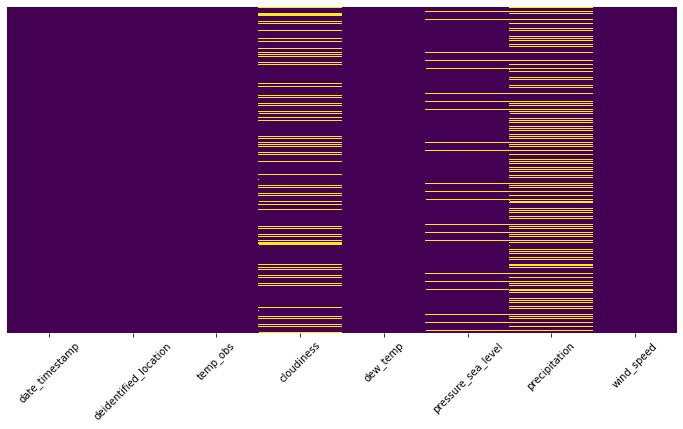

In [94]:
eda.fn_nulls_plot(df_weather)

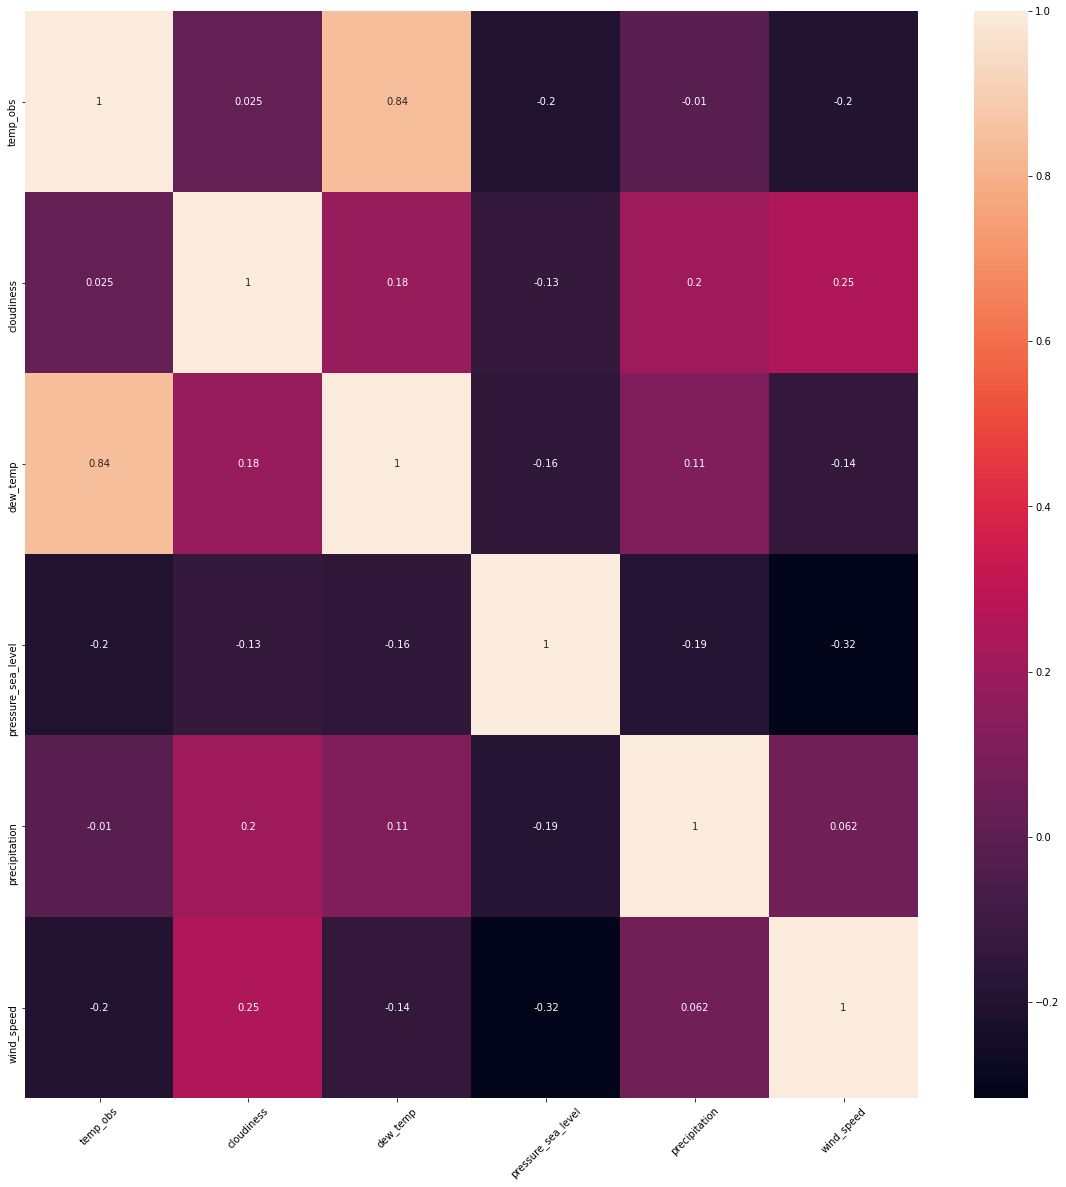

In [95]:
eda.fn_plot_correlation(df_weather)

In [96]:
df_weather.head()

,date_timestamp,deidentified_location,temp_obs,cloudiness,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01,location 1784,-12.239130,0.000000,-16.717391,1035.743478,0.000000,2.869565
1,2016-01-01,location 2532,-6.229167,2.666667,-10.283333,1020.216667,-0.217391,4.737500
2,2016-01-01,location 4525,-1.841667,NaN,-3.270833,1012.554167,3.750000,3.000000
3,2016-01-01,location 5150,-1.357143,NaN,-3.000000,NaN,NaN,4.407143
4,2016-01-01,location 5290,6.679167,7.750000,-0.650000,1020.625000,0.000000,4.133333


In [97]:
df_weather.drop('temp_obs', axis=1, inplace=True)

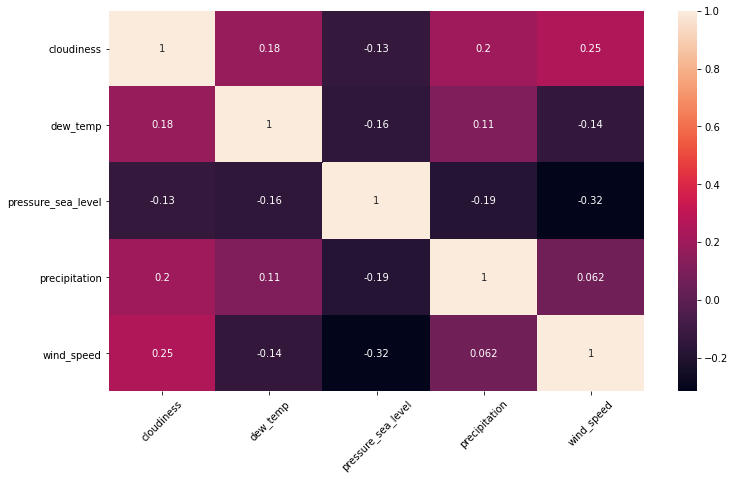

In [101]:
eda.fn_plot_correlation(df_weather)

In [107]:
imputer = SimpleImputer(missing_values='NaN', strategy='median')


In [108]:
df_weather.head()

,date_timestamp,deidentified_location,cloudiness,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01,location 1784,0.000000,-16.717391,1035.743478,0.000000,2.869565
1,2016-01-01,location 2532,2.666667,-10.283333,1020.216667,-0.217391,4.737500
2,2016-01-01,location 4525,NaN,-3.270833,1012.554167,3.750000,3.000000
3,2016-01-01,location 5150,NaN,-3.000000,NaN,NaN,4.407143
4,2016-01-01,location 5290,7.750000,-0.650000,1020.625000,0.000000,4.133333


In [113]:
num_cols = eda.fn_fetch_col_based_ontype(df_weather, 'float64')

In [116]:
num_cols

['cloudiness', 'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed']

In [122]:
df_weather['cloudiness'].fillna(df_weather['cloudiness'].mean(), inplace = True)

In [123]:
df_weather['precipitation'].fillna(df_weather['precipitation'].mean(), inplace = True)
df_weather['pressure_sea_level'].fillna(df_weather['pressure_sea_level'].mean(), inplace = True)

In [124]:
eda.fn_nulls_count(df_weather)

,nulls_count,nulls_percentage
date_timestamp,0,0.0
deidentified_location,0,0.0
cloudiness,0,0.0
dew_temp,0,0.0
pressure_sea_level,0,0.0
precipitation,0,0.0
wind_speed,0,0.0


In [125]:
df_weather.head()

,date_timestamp,deidentified_location,cloudiness,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01,location 1784,0.000000,-16.717391,1035.743478,0.000000,2.869565
1,2016-01-01,location 2532,2.666667,-10.283333,1020.216667,-0.217391,4.737500
2,2016-01-01,location 4525,2.419579,-3.270833,1012.554167,3.750000,3.000000
3,2016-01-01,location 5150,2.419579,-3.000000,1016.148341,1.609910,4.407143
4,2016-01-01,location 5290,7.750000,-0.650000,1020.625000,0.000000,4.133333


In [126]:
data.head()

,date,farm_id,ingredient_type
0,2016-01-01 00:00:00,fid_110884,ing_w
1,2016-01-01 00:00:00,fid_90053,ing_w
2,2016-01-01 00:00:00,fid_17537,ing_w
3,2016-01-01 00:00:00,fid_110392,ing_w
4,2016-01-01 00:00:00,fid_62402,ing_w


In [128]:
data['date_part'] = data['date'].dt.date

In [129]:
data.drop('date', axis=1, inplace=True)

In [130]:
data.head()

,farm_id,ingredient_type,date_part
0,fid_110884,ing_w,2016-01-01
1,fid_90053,ing_w,2016-01-01
2,fid_17537,ing_w,2016-01-01
3,fid_110392,ing_w,2016-01-01
4,fid_62402,ing_w,2016-01-01


In [131]:
#data['date'] = data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_merge_farm_train = pd.merge(data, farm_data, on="farm_id")

In [132]:
df_merge_farm_train.head()

,farm_id,ingredient_type,date_part,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
2,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
3,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
4,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369


In [135]:
df_merge_farm_train.tail()

,farm_id,ingredient_type,date_part,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
20602894,fid_19864,ing_w,2016-12-31,1962.0,NaN,4598.6985,Obery Farms,location 5290
20602895,fid_19864,ing_w,2016-12-31,1962.0,NaN,4598.6985,Obery Farms,location 5290
20602896,fid_19864,ing_w,2016-12-31,1962.0,NaN,4598.6985,Obery Farms,location 5290
20602897,fid_19864,ing_w,2016-12-31,1962.0,NaN,4598.6985,Obery Farms,location 5290
20602898,fid_19864,ing_w,2016-12-31,1962.0,NaN,4598.6985,Obery Farms,location 5290


In [140]:
df_merge_farm_train.nunique()

farm_id                       1434
ingredient_type                  4
date_part                      366
operations_commencing_year     116
num_processing_plants           18
farm_area                     1397
farming_company                 16
deidentified_location           16
dtype: int64

In [144]:
weather_data.nunique()

deidentified_location     16
temp_obs                 619
cloudiness                10
wind_direction            43
dew_temp                 522
pressure_sea_level       709
precipitation            128
wind_speed                58
date_timestamp           366
dtype: int64

In [147]:
len(df_weather[df_weather.deidentified_location == 'location 1784'].date_timestamp)

366

In [162]:
len(df_merge_farm_train[df_merge_farm_train.deidentified_location == 'location 1784'].date_part)

411407

In [163]:
df_merge_farm_train[df_merge_farm_train.deidentified_location == 'location 1784']

In [150]:
df_merge_farm_train.dtypes

farm_id                        object
ingredient_type                object
date_part                      object
operations_commencing_year    float64
num_processing_plants         float64
farm_area                     float64
farming_company                object
deidentified_location          object
dtype: object

In [149]:
df_merge_farm_train.head()

,farm_id,ingredient_type,date_part,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
2,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
3,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369
4,fid_110884,ing_w,2016-01-01,2008.0,NaN,690.455096,Obery Farms,location 7369


In [160]:
df3 = df_merge_farm_train.groupby(['date_part', 'deidentified_location']).\
agg({'farm_area':np.mean}).reset_index()

SyntaxError: ignored

In [154]:
df3.head()

,date_part,deidentified_location,farm_area
0,2016-01-01,location 1784,7511.390030
1,2016-01-01,location 2532,13682.859566
2,2016-01-01,location 4525,31142.808729
3,2016-01-01,location 5150,8096.523845
4,2016-01-01,location 5290,7002.159480


In [155]:
len(df3[df3.deidentified_location == 'location 1784'].date_part)

366